# GraphCodeBERT Embeddings & Classification
Generate GraphCodeBERT (CLS-token) embeddings for code snippets, train multiple classifiers, and produce ensemble predictions for SemEval Task 13 Subtask A.

## Embedding Generation
Load train/val/test data, tokenize with GraphCodeBERT, extract [CLS] embeddings, and save in chunks.

## Contents

### Part 1 — GraphCodeBERT
1. Embedding Generation
2. Inference Pipeline
3. Diagnosis & Analysis
4. Model Evaluation
    - Alternative Ensemble Optimization
5. Model Training Pipeline
6. Ensemble Strategies

### Part 2 — CodeT5+
7. Embedding Generation (CodeT5+)
8. Model Training Pipeline (CodeT5+)
9. Ensemble Strategies (CodeT5+)

### Part 3 — CodeRankLLM
10. Embedding Generation (CodeRankLLM)
11. Model Training Pipeline (CodeRankLLM)
12. Ensemble Strategies (CodeRankLLM)

In [ ]:
import torch
import numpy as np
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

MODEL_NAME = "microsoft/graphcodebert-base"
BATCH_SIZE = 64
MAX_LEN = 512
SAVE_ROOT = "embeddings_graphcodebert"

In [ ]:
DATA_DIR = 'data/semeval'

def load_parquet_safe(filename):
    path = f'{DATA_DIR}/{filename}'
    if os.path.exists(path):
        return pd.read_parquet(path)

    parent_dir = os.path.dirname(DATA_DIR)
    path_fallback = f'{parent_dir}/{filename}'
    if os.path.exists(path_fallback):
        return pd.read_parquet(path_fallback)

    return None

df_train = load_parquet_safe('train.parquet')
df_val = load_parquet_safe('validation.parquet')
df_test = load_parquet_safe('test.parquet')

print(f"Train: {df_train.shape if df_train is not None else 'Not found'}")
print(f"Val:   {df_val.shape if df_val is not None else 'Not found'}")
print(f"Test:  {df_test.shape if df_test is not None else 'Not found'}")

In [ ]:
def get_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    return tokenizer, model, device

def process_dataset(df, dataset_name, tokenizer, model, device, save_root):
    if df is None:
        return

    save_dir = os.path.join(save_root, dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    col_name = "code_snippet" if "code_snippet" in df.columns else "code"
    texts = df[col_name].astype(str).tolist()

    has_labels = "label" in df.columns
    if has_labels:
        labels = df["label"].to_numpy()

    chunk_embs = []
    chunk_labels = []
    chunk_counter = 0
    CHUNK_SIZE = 20000

    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"Embedding {dataset_name}"):
        batch_text = texts[i : i + BATCH_SIZE]

        with torch.no_grad():
            enc = tokenizer(
                batch_text,
                padding=True,
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            ).to(device)

            out = model(**enc)
            embeddings = out.last_hidden_state[:, 0, :]
            chunk_embs.append(embeddings.cpu().numpy())

        if has_labels:
            chunk_labels.append(labels[i : i + BATCH_SIZE])

        if sum(len(x) for x in chunk_embs) >= CHUNK_SIZE:
            arr_X = np.vstack(chunk_embs)
            np.save(f"{save_dir}/X_part_{chunk_counter}.npy", arr_X)

            if has_labels:
                arr_y = np.concatenate(chunk_labels)
                np.save(f"{save_dir}/y_part_{chunk_counter}.npy", arr_y)

            chunk_embs = []
            chunk_labels = []
            chunk_counter += 1

    if chunk_embs:
        np.save(f"{save_dir}/X_part_{chunk_counter}.npy", np.vstack(chunk_embs))
        if has_labels:
            np.save(f"{save_dir}/y_part_{chunk_counter}.npy", np.concatenate(chunk_labels))

In [ ]:
tokenizer, model, device = get_model_and_tokenizer()

process_dataset(df_train, "train", tokenizer, model, device, SAVE_ROOT)
process_dataset(df_val, "val", tokenizer, model, device, SAVE_ROOT)
process_dataset(df_test, "test", tokenizer, model, device, SAVE_ROOT)

## Inference Pipeline
Load pre-trained models and test embeddings, generate predictions via simple averaging, and save submission.

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import joblib

INPUT_DIR = "data/training-codebert"
EMBED_DIR = "data/embeddings_graphcodebert"
MODEL_DIR = f"{INPUT_DIR}/saved_models"
RAW_DATA_DIR = "data/semeval"

def load_test_data():
    search_path = f"{EMBED_DIR}/test"
    if not os.path.exists(search_path):
        search_path = EMBED_DIR

    x_files = sorted(glob.glob(f"{search_path}/X_part_*.npy"),
                     key=lambda x: int(x.split('_')[-1].split('.')[0]))

    if not x_files:
        raise ValueError(f"No test embeddings found in {search_path}")

    X = np.vstack([np.load(f) for f in x_files])
    return X

def load_model(name):
    path = f"{MODEL_DIR}/{name}.joblib"
    if not os.path.exists(path):
        return None
    return joblib.load(path)

def get_test_ids_robust(expected_len):
    path = f'{RAW_DATA_DIR}/test.parquet'

    if not os.path.exists(path):
        return np.arange(expected_len)

    try:
        df_sample = pd.read_parquet(path).head(1)
        cols = df_sample.columns.tolist()

        if 'ID' in cols:
            ids = pd.read_parquet(path, columns=["ID"])["ID"].values
        elif 'id' in cols:
            ids = pd.read_parquet(path, columns=["id"])["id"].values
        else:
            return np.arange(expected_len)

    except Exception:
        return np.arange(expected_len)

    if len(ids) > expected_len:
        ids = ids[:expected_len]
    return ids

X_test = load_test_data()
test_ids = get_test_ids_robust(len(X_test))

xgb_model = load_model("xgb_model")
lgb_model = load_model("lgb_model")
mlp_model = load_model("mlp_model")
lr_model  = load_model("lr_model")

probs = []
if xgb_model: probs.append(xgb_model.predict_proba(X_test)[:, 1])
if lgb_model: probs.append(lgb_model.predict_proba(X_test)[:, 1])
if mlp_model: probs.append(mlp_model.predict_proba(X_test)[:, 1])
if lr_model:  probs.append(lr_model.predict_proba(X_test)[:, 1])

if not probs:
    raise ValueError("No models loaded!")

avg_prob = np.mean(probs, axis=0)
preds = (avg_prob > 0.5).astype(int)

pd.DataFrame({"ID": test_ids, "label": preds}).to_csv("submission_final_fix.csv", index=False)

Loading Test Embeddings...
✅ Loaded Test Data: (1000, 768)
Loading Test IDs...
   -> Found column 'ID' (Uppercase)
Loading Models...
Predicting...
🎉 Saved 'submission_final_fix.csv'


## Diagnosis & Analysis
Load raw datasets and embeddings. Inspect test set structure, detect languages via heuristics, and visualize train vs test embedding distributions with PCA.

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import joblib
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

INPUT_DIR = "data/training-codebert"
EMBED_DIR = "data/embeddings_graphcodebert"
MODEL_DIR = "data/training-codebert/saved_models"

def load_data(folder_name):
    search_path = f"{EMBED_DIR}/{folder_name}"

    x_files = sorted(glob.glob(f"{search_path}/X_part_*.npy"),
                     key=lambda x: int(x.split('_')[-1].split('.')[0]))
    y_files = sorted(glob.glob(f"{search_path}/y_part_*.npy"),
                     key=lambda x: int(x.split('_')[-1].split('.')[0]))

    if not x_files:
        return None, None

    X = np.vstack([np.load(f) for f in x_files])
    y = np.concatenate([np.load(f) for f in y_files]) if y_files else None
    return X, y

def get_test_ids():
    paths = [
        'data/semeval/test.parquet',
        'data/semeval/validation.parquet'
    ]
    for p in paths:
        if os.path.exists(p):
            try:
                return pd.read_parquet(p, columns=["id"])["id"].values
            except:
                return pd.read_parquet(p, columns=["ID"])["ID"].values
    return np.arange(1000)

X_val, y_val = load_data("val")
X_test, _    = load_data("test")
test_ids = get_test_ids()
if len(test_ids) > len(X_test): test_ids = test_ids[:len(X_test)]

--- Loading Validation & Test Data ---
Loading val...
   -> Loaded (100000, 768)
Loading test...
   -> Loaded (1000, 768)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RAW_DATA_DIR = "data/semeval"
EMBED_DIR = "data/embeddings_graphcodebert"

df_train = pd.read_parquet(f'{RAW_DATA_DIR}/train.parquet')
df_val = pd.read_parquet(f'{RAW_DATA_DIR}/validation.parquet')

test_path = f'{RAW_DATA_DIR}/test.parquet'
if not os.path.exists(test_path):
    test_path = f'{os.path.dirname(RAW_DATA_DIR)}/test.parquet'

df_test = pd.read_parquet(test_path)
print(f"Train Shape: {df_train.shape}")
print(f"Test Shape:  {df_test.shape}")
print(f"Test Columns: {df_test.columns.tolist()}")

if 'label' in df_test.columns:
    print(f"Test Label Distribution: {df_test['label'].value_counts().to_dict()}")
else:
    print("Test set has no labels (Blind Test).")

--- Loading Raw Parquet Files ---
✅ Train Shape: (500000, 4)
✅ Test Shape:  (1000, 2)
   Test Columns: ['ID', 'code']
   ❌ Test set has NO labels (Blind Test).


Loading Data...
Scanning Test Set for Languages...


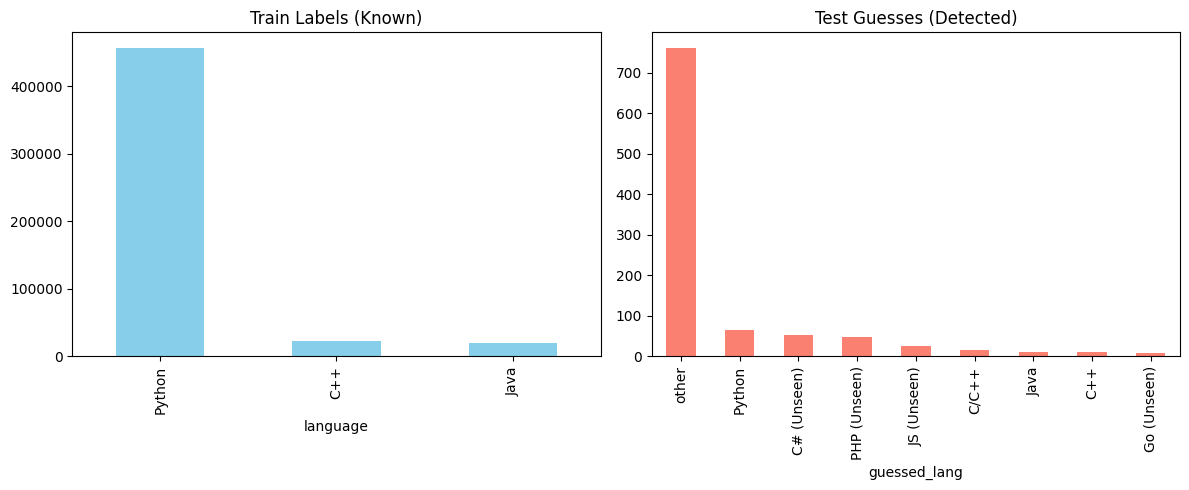


--- Detected Distribution ---
guessed_lang
other           761
Python           66
C# (Unseen)      53
PHP (Unseen)     49
JS (Unseen)      25
C/C++            15
Java             12
C++              10
Go (Unseen)       9
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

RAW_DATA_DIR = "data/semeval"

df_train = pd.read_parquet(f'{RAW_DATA_DIR}/train.parquet')

test_path = f'{RAW_DATA_DIR}/test.parquet'
if not os.path.exists(test_path):
    test_path = f'{os.path.dirname(RAW_DATA_DIR)}/test.parquet'
df_test = pd.read_parquet(test_path)

def guess_language(code):
    code = str(code).lower()

    if 'package main' in code or 'func main' in code: return 'Go (Unseen)'
    if '<?php' in code or '$' in code and 'echo' in code: return 'PHP (Unseen)'
    if 'using system;' in code or 'namespace' in code: return 'C# (Unseen)'
    if 'console.log' in code or 'function' in code and 'var ' in code: return 'JS (Unseen)'

    if '#include' in code and 'std::' in code: return 'C++'
    if 'public class' in code and 'system.out' in code: return 'Java'
    if 'def ' in code and 'import ' in code and ':' in code: return 'Python'

    if '#include' in code: return 'C/C++'
    return 'other'

col = "code_snippet" if "code_snippet" in df_test.columns else "code"
df_test['guessed_lang'] = df_test[col].apply(guess_language)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_train['language'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Train Labels (Known)")

plt.subplot(1, 2, 2)
df_test['guessed_lang'].value_counts().plot(kind='bar', color='salmon')
plt.title("Test Guesses (Detected)")

plt.tight_layout()
plt.show()

print(df_test['guessed_lang'].value_counts())


--- Loading Embeddings ---


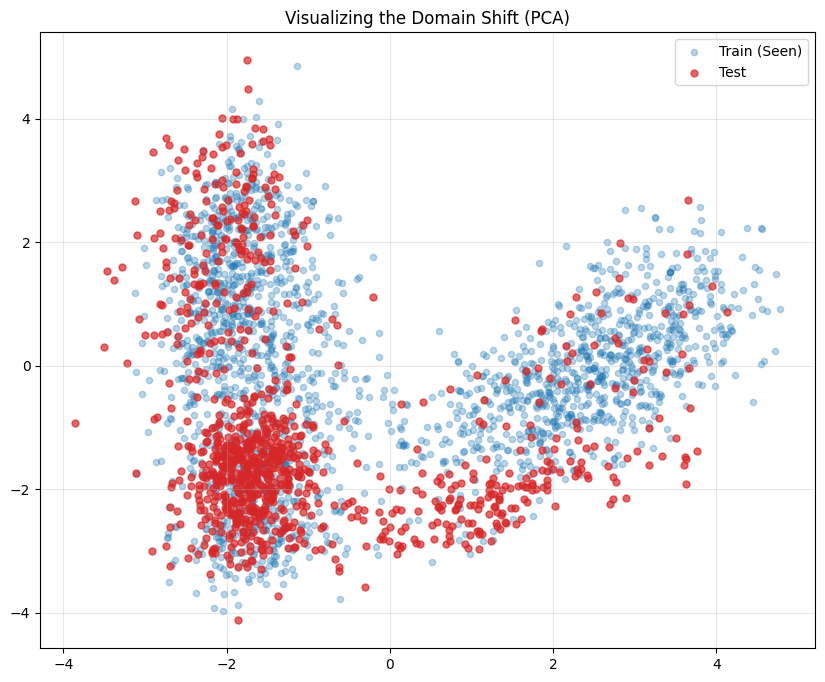

In [ ]:
import glob
from sklearn.decomposition import PCA

EMBED_DIR = "data/embeddings_graphcodebert"

def load_chunk_0(folder):
    files = sorted(glob.glob(f"{EMBED_DIR}/{folder}/X_part_*.npy"))
    if not files: return None
    return np.load(files[0])

X_train_sample = load_chunk_0("train")
X_test_sample  = load_chunk_0("test")

if X_train_sample is not None and X_test_sample is not None:
    idx = np.random.choice(len(X_train_sample), size=min(2000, len(X_train_sample)), replace=False)
    X_train_viz = X_train_sample[idx]
    X_test_viz = X_test_sample[:2000]

    pca = PCA(n_components=2)
    pca.fit(X_train_viz)

    train_2d = pca.transform(X_train_viz)
    test_2d = pca.transform(X_test_viz)

    plt.figure(figsize=(10, 8))
    plt.scatter(train_2d[:, 0], train_2d[:, 1], alpha=0.3, label='Train (Seen)', s=20, color='#1f77b4')
    plt.scatter(test_2d[:, 0], test_2d[:, 1], alpha=0.7, label='Test', s=25, color='#d62728')
    plt.title("Visualizing the Domain Shift (PCA)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Model Evaluation
Load saved models, predict on validation set, report per-model F1 scores and confusion matrices. Then optimize ensemble weights via SLSQP to maximize macro-F1 and generate a submission.

In [ ]:
import joblib
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def load_model(name):
    path = f"{MODEL_DIR}/{name}.joblib"
    if os.path.exists(path):
        return joblib.load(path)
    return None

lr_model  = load_model("lr_model")
xgb_model = load_model("xgb_model")
lgb_model = load_model("lgb_model")
mlp_model = load_model("mlp_model")

models = {
    "LogisticRegression": lr_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model,
    "MLP": mlp_model
}

val_probs = {}
test_probs = {}

for name, model in models.items():
    if model is None: continue

    try:
        p_val = model.predict(X_val)
        prob_val = model.predict_proba(X_val)[:, 1]
        prob_test = model.predict_proba(X_test)[:, 1]
    except Exception as e:
        print(f"Error predicting with {name}: {e}")
        continue

    val_probs[name] = prob_val
    test_probs[name] = prob_test

    score = f1_score(y_val, p_val, average='macro')
    print(f"{name} F1 Score: {score:.4f}")

    cm = confusion_matrix(y_val, p_val)
    print(f"  Confusion Matrix:")
    print(f"  {cm[0]}  <- Human")
    print(f"  {cm[1]}  <- Machine")


--- Loading Models ---
✅ Loaded lr_model
✅ Loaded xgb_model
✅ Loaded lgb_model
✅ Loaded mlp_model

--- Model Diagnosis (Validation Set) ---

📊 LogisticRegression F1 Score: 0.9700
   Confusion Matrix: [TN FP] [FN TP]
   [46277  1418]  <-- Actual Humans
   [ 1574 50731]  <-- Actual Machines

📊 XGBoost F1 Score: 0.9791
   Confusion Matrix: [TN FP] [FN TP]
   [46648  1047]  <-- Actual Humans
   [ 1038 51267]  <-- Actual Machines

📊 LightGBM F1 Score: 0.9806
   Confusion Matrix: [TN FP] [FN TP]
   [46708   987]  <-- Actual Humans
   [  946 51359]  <-- Actual Machines

📊 MLP F1 Score: 0.9868
   Confusion Matrix: [TN FP] [FN TP]
   [46915   780]  <-- Actual Humans
   [  535 51770]  <-- Actual Machines


In [ ]:
from scipy.optimize import minimize

valid_model_names = list(val_probs.keys())
if not valid_model_names:
    raise ValueError("No models loaded successfully!")

P_val_matrix = np.column_stack([val_probs[n] for n in valid_model_names])
P_test_matrix = np.column_stack([test_probs[n] for n in valid_model_names])

def neg_f1(weights):
    w = np.array(weights)
    if np.sum(np.abs(w)) == 0: return 0
    w = w / np.sum(np.abs(w))
    w_avg = np.average(P_val_matrix, axis=1, weights=w)
    return -f1_score(y_val, (w_avg > 0.5).astype(int), average='macro')

start_w = [1.0 / len(valid_model_names)] * len(valid_model_names)
bounds = [(0, 1)] * len(valid_model_names)

res = minimize(neg_f1, start_w, bounds=bounds, method='SLSQP')
best_w = res.x / np.sum(res.x)

print("Best Weights:")
for name, w in zip(valid_model_names, best_w):
    print(f"  {name}: {w:.4f}")

final_val_prob = np.average(P_val_matrix, axis=1, weights=best_w)
final_val_score = f1_score(y_val, (final_val_prob > 0.5).astype(int), average='macro')
print(f"Optimized Ensemble Val F1: {final_val_score:.4f}")


--- Optimizing Ensemble Weights ---

💎 Best Weights:
   LogisticRegression: 0.2500
   XGBoost: 0.2500
   LightGBM: 0.2500
   MLP: 0.2500
🚀 Optimized Ensemble Val F1: 0.9832


In [ ]:
final_test_prob = np.average(P_test_matrix, axis=1, weights=best_w)
final_preds = (final_test_prob > 0.5).astype(int)

sub_df = pd.DataFrame({"ID": test_ids, "label": final_preds})
print(f"Submission shape: {sub_df.shape}")
print(sub_df.head())

sub_df.to_csv("submission_inference_fixed.csv", index=False)


--- Generating Submission ---
Submission shape: (1000, 2)
     ID  label
0  2005      1
1  2384      0
2  3526      0
3  3926      0
4  7222      1
✅ Saved 'submission_inference_fixed.csv'


### Alternative Ensemble Optimization
Re-runs weight optimization and generates a separate submission file.

In [ ]:
model_names = list(val_probs.keys())
P_val_matrix = np.column_stack([val_probs[n] for n in model_names])
P_test_matrix = np.column_stack([test_probs[n] for n in model_names])

def neg_f1(weights):
    w = np.array(weights)
    if np.sum(np.abs(w)) == 0: return 0
    w = w / np.sum(np.abs(w))
    w_avg = np.average(P_val_matrix, axis=1, weights=w)
    return -f1_score(y_val, (w_avg > 0.5).astype(int), average='macro')

start_w = [1.0 / len(model_names)] * len(model_names)
bounds = [(0, 1)] * len(model_names)

res = minimize(neg_f1, start_w, bounds=bounds, method='SLSQP')
best_w = res.x / np.sum(res.x)

print("Best Weights:")
for name, w in zip(model_names, best_w):
    print(f"  {name}: {w:.4f}")

final_val_prob = np.average(P_val_matrix, axis=1, weights=best_w)
final_val_score = f1_score(y_val, (final_val_prob > 0.5).astype(int), average='macro')
print(f"Optimized Ensemble Val F1: {final_val_score:.4f}")


--- Optimizing Ensemble Weights ---

💎 Best Weights Found:
   LogisticRegression: 0.2500
   XGBoost: 0.2500
   LightGBM: 0.2500
   MLP: 0.2500
🚀 Optimized Ensemble Val F1: 0.9832


In [ ]:
final_test_prob = np.average(P_test_matrix, axis=1, weights=best_w)
final_preds = (final_test_prob > 0.5).astype(int)

sub_df = pd.DataFrame({"ID": test_ids, "label": final_preds})
sub_df.to_csv("submission_optimized_ensemble.csv", index=False)
print(sub_df.head())


✅ Saved 'submission_optimized_ensemble.csv'
     ID  label
0  2005      1
1  2384      0
2  3526      0
3  3926      0
4  7222      1


## Model Training Pipeline
Train four classifiers (Logistic Regression, XGBoost, LightGBM, MLP) on GraphCodeBERT embeddings. Each model is evaluated on the validation set, saved to disk, and used to generate an individual submission.

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import joblib
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report

INPUT_DIR = "data/embeddings_graphcodebert"
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

✅ Setup Complete


In [ ]:
import os
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".parquet"):
            print(os.path.join(root, file))

📂 Searching for parquet files...
/kaggle/input/sem-eval-2026-task-13-subtask-a/Task_A/train.parquet
/kaggle/input/sem-eval-2026-task-13-subtask-a/Task_A/test_sample.parquet
/kaggle/input/sem-eval-2026-task-13-subtask-a/Task_A/validation.parquet
/kaggle/input/sem-eval-2026-task-13-subtask-a/Task_A/test.parquet


In [ ]:
RAW_DATA_DIR = 'data/semeval'

def load_embeddings(folder_name):
    x_files = sorted(glob.glob(f"{INPUT_DIR}/{folder_name}/X_part_*.npy"))
    y_files = sorted(glob.glob(f"{INPUT_DIR}/{folder_name}/y_part_*.npy"))

    if not x_files:
        return None, None

    X = np.vstack([np.load(f) for f in x_files])
    y = np.concatenate([np.load(f) for f in y_files]) if y_files else None
    return X, y

def get_test_ids():
    paths = [
        f'{RAW_DATA_DIR}/test.parquet',
        f'{RAW_DATA_DIR}/Task_A/test.parquet',
        'data/semeval/test.parquet',
        f'{RAW_DATA_DIR}/validation.parquet'
    ]

    for p in paths:
        if os.path.exists(p):
            try:
                return pd.read_parquet(p, columns=["id"])["id"].values
            except:
                try:
                    return pd.read_parquet(p, columns=["ID"])["ID"].values
                except:
                    pass
    return None

X_train, y_train = load_embeddings("train")
X_val, y_val     = load_embeddings("val")
X_test, _        = load_embeddings("test")

test_ids = get_test_ids()
if test_ids is None:
    test_ids = np.arange(len(X_test))
else:
    if len(test_ids) > len(X_test):
        test_ids = test_ids[:len(X_test)]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"IDs: {test_ids.shape}")

--- 1. Loading GraphCodeBERT Embeddings ---
Loading embeddings for train...
   -> Loaded (500000, 768)
Loading embeddings for val...
   -> Loaded (100000, 768)
Loading embeddings for test...
   -> Loaded (1000, 768)

--- 2. Loading Test IDs ---
   -> Found ID source: /kaggle/input/sem-eval-2026-task-13-subtask-a/Task_A/test.parquet
      ⚠️ Lowercase 'id' failed. Trying uppercase 'ID'...
✅ Data Loading Verified. IDs shape: (1000,)


In [ ]:
def save_submission(filename, preds):
    pd.DataFrame({"ID": test_ids, "label": preds.astype(int)}).to_csv(filename, index=False)

lr_model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced')
lr_model.fit(X_train, y_train)
p_lr_val = lr_model.predict(X_val)
print(f"LR Val F1: {f1_score(y_val, p_lr_val, average='macro'):.4f}")
joblib.dump(lr_model, f"{MODEL_DIR}/lr_model.joblib")
save_submission("submission_lr.csv", lr_model.predict(X_test))

xgb_model = xgb.XGBClassifier(
    n_estimators=3000, max_depth=8, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.8, tree_method="hist",
    device="cuda", early_stopping_rounds=100
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=500)
p_xgb_val = xgb_model.predict(X_val)
print(f"XGB Val F1: {f1_score(y_val, p_xgb_val, average='macro'):.4f}")
joblib.dump(xgb_model, f"{MODEL_DIR}/xgb_model.joblib")
save_submission("submission_xgboost.csv", xgb_model.predict(X_test))

lgb_model = lgb.LGBMClassifier(
    n_estimators=3000, learning_rate=0.02, num_leaves=64,
    device='gpu', verbose=-1
)
lgb_model.fit(
    X_train, y_train, eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(500)]
)
p_lgb_val = lgb_model.predict(X_val)
print(f"LGB Val F1: {f1_score(y_val, p_lgb_val, average='macro'):.4f}")
joblib.dump(lgb_model, f"{MODEL_DIR}/lgb_model.joblib")
save_submission("submission_lightgbm.csv", lgb_model.predict(X_test))

mlp_model = MLPClassifier(
    hidden_layer_sizes=(512, 128), activation='relu', solver='adam',
    batch_size=256, learning_rate_init=0.001, max_iter=200, early_stopping=True
)
mlp_model.fit(X_train, y_train)
p_mlp_val = mlp_model.predict(X_val)
print(f"MLP Val F1: {f1_score(y_val, p_mlp_val, average='macro'):.4f}")
joblib.dump(mlp_model, f"{MODEL_DIR}/mlp_model.joblib")
save_submission("submission_mlp.csv", mlp_model.predict(X_test))


🤖 Training Logistic Regression...
   LR Val F1: 0.9700
   📄 Saved 'submission_lr.csv'

🚀 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68420


## Ensemble Strategies
Stacking meta-learner and weighted voting optimization over the four base model predictions.

In [ ]:
meta_model = LogisticRegression()
meta_model.fit(P_val, y_val)

meta_preds_val = meta_model.predict(P_val)
print(f"Stacking Val F1: {f1_score(y_val, meta_preds_val, average='macro'):.4f}")

meta_preds_test = meta_model.predict(P_test)
pd.DataFrame({"ID": test_ids, "label": meta_preds_test}).to_csv("submission_ensemble_stacking.csv", index=False)

In [ ]:
def neg_f1(weights):
    w = np.array(weights)
    if np.sum(np.abs(w)) == 0: return 0
    w = w / np.sum(np.abs(w))
    w_avg = np.average(P_val, axis=1, weights=w)
    return -f1_score(y_val, (w_avg > best_t).astype(int), average='macro')

start_w = [0.1, 0.3, 0.3, 0.3]
bounds = [(0, 1)] * 4
res = minimize(neg_f1, start_w, bounds=bounds, method='SLSQP')

best_w = res.x / np.sum(res.x)
print(f"Best Weights: LR={best_w[0]:.2f}, XGB={best_w[1]:.2f}, LGB={best_w[2]:.2f}, MLP={best_w[3]:.2f}")

final_w_probs = np.average(P_test, axis=1, weights=best_w)
preds_strat3 = (final_w_probs > best_t).astype(int)

pd.DataFrame({"ID": test_ids, "label": preds_strat3}).to_csv("submission_ensemble_weighted.csv", index=False)

# CodeT5+ Embeddings & Classification
Generate CodeT5+ encoder embeddings for code snippets and train classifiers on them, mirroring the GraphCodeBERT pipeline above.

## Embedding Generation

In [ ]:
import torch
import numpy as np
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

MODEL_NAME_T5 = "Salesforce/codet5p-110m-embedding"
BATCH_SIZE_T5 = 64
MAX_LEN_T5 = 512
SAVE_ROOT_T5 = "embeddings_codet5p"

In [ ]:
DATA_DIR = 'data/semeval'

def load_parquet_safe(filename):
    path = f'{DATA_DIR}/{filename}'
    if os.path.exists(path):
        return pd.read_parquet(path)

    parent_dir = os.path.dirname(DATA_DIR)
    path_fallback = f'{parent_dir}/{filename}'
    if os.path.exists(path_fallback):
        return pd.read_parquet(path_fallback)

    return None

df_train = load_parquet_safe('train.parquet')
df_val = load_parquet_safe('validation.parquet')
df_test = load_parquet_safe('test.parquet')

print(f"Train: {df_train.shape if df_train is not None else 'Not found'}")
print(f"Val:   {df_val.shape if df_val is not None else 'Not found'}")
print(f"Test:  {df_test.shape if df_test is not None else 'Not found'}")

In [ ]:
def get_codet5p_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_T5, trust_remote_code=True)
    model = AutoModel.from_pretrained(MODEL_NAME_T5, trust_remote_code=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    return tokenizer, model, device

def process_dataset_t5(df, dataset_name, tokenizer, model, device, save_root):
    if df is None:
        return

    save_dir = os.path.join(save_root, dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    col_name = "code_snippet" if "code_snippet" in df.columns else "code"
    texts = df[col_name].astype(str).tolist()

    has_labels = "label" in df.columns
    if has_labels:
        labels = df["label"].to_numpy()

    chunk_embs = []
    chunk_labels = []
    chunk_counter = 0
    CHUNK_SIZE = 20000

    for i in tqdm(range(0, len(texts), BATCH_SIZE_T5), desc=f"Embedding {dataset_name}"):
        batch_text = texts[i : i + BATCH_SIZE_T5]

        with torch.no_grad():
            enc = tokenizer(
                batch_text,
                padding=True,
                truncation=True,
                max_length=MAX_LEN_T5,
                return_tensors="pt"
            ).to(device)

            out = model(**enc)
            embeddings = out.last_hidden_state[:, 0, :]
            chunk_embs.append(embeddings.cpu().numpy())

        if has_labels:
            chunk_labels.append(labels[i : i + BATCH_SIZE_T5])

        if sum(len(x) for x in chunk_embs) >= CHUNK_SIZE:
            arr_X = np.vstack(chunk_embs)
            np.save(f"{save_dir}/X_part_{chunk_counter}.npy", arr_X)

            if has_labels:
                arr_y = np.concatenate(chunk_labels)
                np.save(f"{save_dir}/y_part_{chunk_counter}.npy", arr_y)

            chunk_embs = []
            chunk_labels = []
            chunk_counter += 1

    if chunk_embs:
        np.save(f"{save_dir}/X_part_{chunk_counter}.npy", np.vstack(chunk_embs))
        if has_labels:
            np.save(f"{save_dir}/y_part_{chunk_counter}.npy", np.concatenate(chunk_labels))

In [ ]:
tokenizer_t5, model_t5, device_t5 = get_codet5p_model_and_tokenizer()

process_dataset_t5(df_train, "train", tokenizer_t5, model_t5, device_t5, SAVE_ROOT_T5)
process_dataset_t5(df_val, "val", tokenizer_t5, model_t5, device_t5, SAVE_ROOT_T5)
process_dataset_t5(df_test, "test", tokenizer_t5, model_t5, device_t5, SAVE_ROOT_T5)

## Model Training Pipeline (CodeT5+)
Train four classifiers (Logistic Regression, XGBoost, LightGBM, MLP) on CodeT5+ embeddings. Each model is evaluated on the validation set, saved to disk, and used to generate an individual submission.

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import joblib
import xgboost as xgb
import lightgbm as lgb
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report

INPUT_DIR_T5 = "data/embeddings_codet5p"
MODEL_DIR_T5 = "saved_models_codet5p"
os.makedirs(MODEL_DIR_T5, exist_ok=True)

In [ ]:
RAW_DATA_DIR = 'data/semeval'

def load_embeddings_t5(folder_name):
    x_files = sorted(glob.glob(f"{INPUT_DIR_T5}/{folder_name}/X_part_*.npy"))
    y_files = sorted(glob.glob(f"{INPUT_DIR_T5}/{folder_name}/y_part_*.npy"))

    if not x_files:
        return None, None

    X = np.vstack([np.load(f) for f in x_files])
    y = np.concatenate([np.load(f) for f in y_files]) if y_files else None
    return X, y

def get_test_ids():
    paths = [
        f'{RAW_DATA_DIR}/test.parquet',
        f'{RAW_DATA_DIR}/Task_A/test.parquet',
        f'{RAW_DATA_DIR}/validation.parquet'
    ]
    for p in paths:
        if os.path.exists(p):
            try:
                return pd.read_parquet(p, columns=["id"])["id"].values
            except:
                try:
                    return pd.read_parquet(p, columns=["ID"])["ID"].values
                except:
                    pass
    return None

X_train_t5, y_train_t5 = load_embeddings_t5("train")
X_val_t5, y_val_t5     = load_embeddings_t5("val")
X_test_t5, _           = load_embeddings_t5("test")

test_ids_t5 = get_test_ids()
if test_ids_t5 is None:
    test_ids_t5 = np.arange(len(X_test_t5))
else:
    if len(test_ids_t5) > len(X_test_t5):
        test_ids_t5 = test_ids_t5[:len(X_test_t5)]

print(f"Train: {X_train_t5.shape}, Val: {X_val_t5.shape}, Test: {X_test_t5.shape}")
print(f"IDs: {test_ids_t5.shape}")

In [ ]:
def save_submission_t5(filename, preds):
    pd.DataFrame({"ID": test_ids_t5, "label": preds.astype(int)}).to_csv(filename, index=False)

lr_model_t5 = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced')
lr_model_t5.fit(X_train_t5, y_train_t5)
p_lr_val_t5 = lr_model_t5.predict(X_val_t5)
print(f"LR Val F1: {f1_score(y_val_t5, p_lr_val_t5, average='macro'):.4f}")
joblib.dump(lr_model_t5, f"{MODEL_DIR_T5}/lr_model.joblib")
save_submission_t5("submission_codet5p_lr.csv", lr_model_t5.predict(X_test_t5))

xgb_model_t5 = xgb.XGBClassifier(
    n_estimators=3000, max_depth=8, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.8, tree_method="hist",
    device="cuda", early_stopping_rounds=100
)
xgb_model_t5.fit(X_train_t5, y_train_t5, eval_set=[(X_val_t5, y_val_t5)], verbose=500)
p_xgb_val_t5 = xgb_model_t5.predict(X_val_t5)
print(f"XGB Val F1: {f1_score(y_val_t5, p_xgb_val_t5, average='macro'):.4f}")
joblib.dump(xgb_model_t5, f"{MODEL_DIR_T5}/xgb_model.joblib")
save_submission_t5("submission_codet5p_xgboost.csv", xgb_model_t5.predict(X_test_t5))

lgb_model_t5 = lgb.LGBMClassifier(
    n_estimators=3000, learning_rate=0.02, num_leaves=64,
    device='gpu', verbose=-1
)
lgb_model_t5.fit(
    X_train_t5, y_train_t5, eval_set=[(X_val_t5, y_val_t5)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(500)]
)
p_lgb_val_t5 = lgb_model_t5.predict(X_val_t5)
print(f"LGB Val F1: {f1_score(y_val_t5, p_lgb_val_t5, average='macro'):.4f}")
joblib.dump(lgb_model_t5, f"{MODEL_DIR_T5}/lgb_model.joblib")
save_submission_t5("submission_codet5p_lightgbm.csv", lgb_model_t5.predict(X_test_t5))

mlp_model_t5 = MLPClassifier(
    hidden_layer_sizes=(512, 128), activation='relu', solver='adam',
    batch_size=256, learning_rate_init=0.001, max_iter=200, early_stopping=True
)
mlp_model_t5.fit(X_train_t5, y_train_t5)
p_mlp_val_t5 = mlp_model_t5.predict(X_val_t5)
print(f"MLP Val F1: {f1_score(y_val_t5, p_mlp_val_t5, average='macro'):.4f}")
joblib.dump(mlp_model_t5, f"{MODEL_DIR_T5}/mlp_model.joblib")
save_submission_t5("submission_codet5p_mlp.csv", mlp_model_t5.predict(X_test_t5))

## Ensemble Strategies (CodeT5+)
Stacking meta-learner and weighted voting optimization over the four CodeT5+ base model predictions.

In [ ]:
val_probs_t5 = {
    "LR": lr_model_t5.predict_proba(X_val_t5)[:, 1],
    "XGB": xgb_model_t5.predict_proba(X_val_t5)[:, 1],
    "LGB": lgb_model_t5.predict_proba(X_val_t5)[:, 1],
    "MLP": mlp_model_t5.predict_proba(X_val_t5)[:, 1],
}
test_probs_t5 = {
    "LR": lr_model_t5.predict_proba(X_test_t5)[:, 1],
    "XGB": xgb_model_t5.predict_proba(X_test_t5)[:, 1],
    "LGB": lgb_model_t5.predict_proba(X_test_t5)[:, 1],
    "MLP": mlp_model_t5.predict_proba(X_test_t5)[:, 1],
}

P_val_t5 = np.column_stack(list(val_probs_t5.values()))
P_test_t5 = np.column_stack(list(test_probs_t5.values()))

meta_model_t5 = LogisticRegression()
meta_model_t5.fit(P_val_t5, y_val_t5)

meta_preds_val_t5 = meta_model_t5.predict(P_val_t5)
print(f"Stacking Val F1: {f1_score(y_val_t5, meta_preds_val_t5, average='macro'):.4f}")

meta_preds_test_t5 = meta_model_t5.predict(P_test_t5)
pd.DataFrame({"ID": test_ids_t5, "label": meta_preds_test_t5}).to_csv("submission_codet5p_stacking.csv", index=False)

In [ ]:
model_names_t5 = list(val_probs_t5.keys())

def neg_f1_t5(weights):
    w = np.array(weights)
    if np.sum(np.abs(w)) == 0: return 0
    w = w / np.sum(np.abs(w))
    w_avg = np.average(P_val_t5, axis=1, weights=w)
    return -f1_score(y_val_t5, (w_avg > 0.5).astype(int), average='macro')

start_w = [1.0 / len(model_names_t5)] * len(model_names_t5)
bounds = [(0, 1)] * len(model_names_t5)

res = minimize(neg_f1_t5, start_w, bounds=bounds, method='SLSQP')
best_w_t5 = res.x / np.sum(res.x)

print("Best Weights:")
for name, w in zip(model_names_t5, best_w_t5):
    print(f"  {name}: {w:.4f}")

final_val_prob_t5 = np.average(P_val_t5, axis=1, weights=best_w_t5)
final_val_score_t5 = f1_score(y_val_t5, (final_val_prob_t5 > 0.5).astype(int), average='macro')
print(f"Optimized Ensemble Val F1: {final_val_score_t5:.4f}")

final_test_prob_t5 = np.average(P_test_t5, axis=1, weights=best_w_t5)
final_preds_t5 = (final_test_prob_t5 > 0.5).astype(int)

pd.DataFrame({"ID": test_ids_t5, "label": final_preds_t5}).to_csv("submission_codet5p_weighted.csv", index=False)
print(f"Submission shape: {final_preds_t5.shape}")

# CodeRankLLM Embeddings & Classification
Generate CodeRankLLM encoder embeddings for code snippets and train classifiers on them, mirroring the pipelines above.

## Embedding Generation

In [ ]:
import torch
import numpy as np
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

MODEL_NAME_CR = "nomicai/CodeRankLLM"
BATCH_SIZE_CR = 64
MAX_LEN_CR = 512
SAVE_ROOT_CR = "embeddings_coderankllm"

In [ ]:
DATA_DIR = 'data/semeval'

def load_parquet_safe(filename):
    path = f'{DATA_DIR}/{filename}'
    if os.path.exists(path):
        return pd.read_parquet(path)

    parent_dir = os.path.dirname(DATA_DIR)
    path_fallback = f'{parent_dir}/{filename}'
    if os.path.exists(path_fallback):
        return pd.read_parquet(path_fallback)

    return None

df_train = load_parquet_safe('train.parquet')
df_val = load_parquet_safe('validation.parquet')
df_test = load_parquet_safe('test.parquet')

print(f"Train: {df_train.shape if df_train is not None else 'Not found'}")
print(f"Val:   {df_val.shape if df_val is not None else 'Not found'}")
print(f"Test:  {df_test.shape if df_test is not None else 'Not found'}")

In [ ]:
def get_coderankllm_model_and_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_CR, trust_remote_code=True)
    model = AutoModel.from_pretrained(MODEL_NAME_CR, trust_remote_code=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    return tokenizer, model, device

def process_dataset_cr(df, dataset_name, tokenizer, model, device, save_root):
    if df is None:
        return

    save_dir = os.path.join(save_root, dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    col_name = "code_snippet" if "code_snippet" in df.columns else "code"
    texts = df[col_name].astype(str).tolist()

    has_labels = "label" in df.columns
    if has_labels:
        labels = df["label"].to_numpy()

    chunk_embs = []
    chunk_labels = []
    chunk_counter = 0
    CHUNK_SIZE = 20000

    for i in tqdm(range(0, len(texts), BATCH_SIZE_CR), desc=f"Embedding {dataset_name}"):
        batch_text = texts[i : i + BATCH_SIZE_CR]

        with torch.no_grad():
            enc = tokenizer(
                batch_text,
                padding=True,
                truncation=True,
                max_length=MAX_LEN_CR,
                return_tensors="pt"
            ).to(device)

            out = model(**enc)
            embeddings = out.last_hidden_state[:, 0, :]
            chunk_embs.append(embeddings.cpu().numpy())

        if has_labels:
            chunk_labels.append(labels[i : i + BATCH_SIZE_CR])

        if sum(len(x) for x in chunk_embs) >= CHUNK_SIZE:
            arr_X = np.vstack(chunk_embs)
            np.save(f"{save_dir}/X_part_{chunk_counter}.npy", arr_X)

            if has_labels:
                arr_y = np.concatenate(chunk_labels)
                np.save(f"{save_dir}/y_part_{chunk_counter}.npy", arr_y)

            chunk_embs = []
            chunk_labels = []
            chunk_counter += 1

    if chunk_embs:
        np.save(f"{save_dir}/X_part_{chunk_counter}.npy", np.vstack(chunk_embs))
        if has_labels:
            np.save(f"{save_dir}/y_part_{chunk_counter}.npy", np.concatenate(chunk_labels))

In [ ]:
tokenizer_cr, model_cr, device_cr = get_coderankllm_model_and_tokenizer()

process_dataset_cr(df_train, "train", tokenizer_cr, model_cr, device_cr, SAVE_ROOT_CR)
process_dataset_cr(df_val, "val", tokenizer_cr, model_cr, device_cr, SAVE_ROOT_CR)
process_dataset_cr(df_test, "test", tokenizer_cr, model_cr, device_cr, SAVE_ROOT_CR)

## Model Training Pipeline (CodeRankLLM)
Train four classifiers (Logistic Regression, XGBoost, LightGBM, MLP) on CodeRankLLM embeddings. Each model is evaluated on the validation set, saved to disk, and used to generate an individual submission.

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import joblib
import xgboost as xgb
import lightgbm as lgb
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report

INPUT_DIR_CR = "data/embeddings_coderankllm"
MODEL_DIR_CR = "saved_models_coderankllm"
os.makedirs(MODEL_DIR_CR, exist_ok=True)

In [ ]:
RAW_DATA_DIR = 'data/semeval'

def load_embeddings_cr(folder_name):
    x_files = sorted(glob.glob(f"{INPUT_DIR_CR}/{folder_name}/X_part_*.npy"))
    y_files = sorted(glob.glob(f"{INPUT_DIR_CR}/{folder_name}/y_part_*.npy"))

    if not x_files:
        return None, None

    X = np.vstack([np.load(f) for f in x_files])
    y = np.concatenate([np.load(f) for f in y_files]) if y_files else None
    return X, y

def get_test_ids():
    paths = [
        f'{RAW_DATA_DIR}/test.parquet',
        f'{RAW_DATA_DIR}/Task_A/test.parquet',
        f'{RAW_DATA_DIR}/validation.parquet'
    ]
    for p in paths:
        if os.path.exists(p):
            try:
                return pd.read_parquet(p, columns=["id"])["id"].values
            except:
                try:
                    return pd.read_parquet(p, columns=["ID"])["ID"].values
                except:
                    pass
    return None

X_train_cr, y_train_cr = load_embeddings_cr("train")
X_val_cr, y_val_cr     = load_embeddings_cr("val")
X_test_cr, _           = load_embeddings_cr("test")

test_ids_cr = get_test_ids()
if test_ids_cr is None:
    test_ids_cr = np.arange(len(X_test_cr))
else:
    if len(test_ids_cr) > len(X_test_cr):
        test_ids_cr = test_ids_cr[:len(X_test_cr)]

print(f"Train: {X_train_cr.shape}, Val: {X_val_cr.shape}, Test: {X_test_cr.shape}")
print(f"IDs: {test_ids_cr.shape}")

In [ ]:
def save_submission_cr(filename, preds):
    pd.DataFrame({"ID": test_ids_cr, "label": preds.astype(int)}).to_csv(filename, index=False)

lr_model_cr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced')
lr_model_cr.fit(X_train_cr, y_train_cr)
p_lr_val_cr = lr_model_cr.predict(X_val_cr)
print(f"LR Val F1: {f1_score(y_val_cr, p_lr_val_cr, average='macro'):.4f}")
joblib.dump(lr_model_cr, f"{MODEL_DIR_CR}/lr_model.joblib")
save_submission_cr("submission_coderankllm_lr.csv", lr_model_cr.predict(X_test_cr))

xgb_model_cr = xgb.XGBClassifier(
    n_estimators=3000, max_depth=8, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.8, tree_method="hist",
    device="cuda", early_stopping_rounds=100
)
xgb_model_cr.fit(X_train_cr, y_train_cr, eval_set=[(X_val_cr, y_val_cr)], verbose=500)
p_xgb_val_cr = xgb_model_cr.predict(X_val_cr)
print(f"XGB Val F1: {f1_score(y_val_cr, p_xgb_val_cr, average='macro'):.4f}")
joblib.dump(xgb_model_cr, f"{MODEL_DIR_CR}/xgb_model.joblib")
save_submission_cr("submission_coderankllm_xgboost.csv", xgb_model_cr.predict(X_test_cr))

lgb_model_cr = lgb.LGBMClassifier(
    n_estimators=3000, learning_rate=0.02, num_leaves=64,
    device='gpu', verbose=-1
)
lgb_model_cr.fit(
    X_train_cr, y_train_cr, eval_set=[(X_val_cr, y_val_cr)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(500)]
)
p_lgb_val_cr = lgb_model_cr.predict(X_val_cr)
print(f"LGB Val F1: {f1_score(y_val_cr, p_lgb_val_cr, average='macro'):.4f}")
joblib.dump(lgb_model_cr, f"{MODEL_DIR_CR}/lgb_model.joblib")
save_submission_cr("submission_coderankllm_lightgbm.csv", lgb_model_cr.predict(X_test_cr))

mlp_model_cr = MLPClassifier(
    hidden_layer_sizes=(512, 128), activation='relu', solver='adam',
    batch_size=256, learning_rate_init=0.001, max_iter=200, early_stopping=True
)
mlp_model_cr.fit(X_train_cr, y_train_cr)
p_mlp_val_cr = mlp_model_cr.predict(X_val_cr)
print(f"MLP Val F1: {f1_score(y_val_cr, p_mlp_val_cr, average='macro'):.4f}")
joblib.dump(mlp_model_cr, f"{MODEL_DIR_CR}/mlp_model.joblib")
save_submission_cr("submission_coderankllm_mlp.csv", mlp_model_cr.predict(X_test_cr))

## Ensemble Strategies (CodeRankLLM)
Stacking meta-learner and weighted voting optimization over the four CodeRankLLM base model predictions.

In [ ]:
val_probs_cr = {
    "LR": lr_model_cr.predict_proba(X_val_cr)[:, 1],
    "XGB": xgb_model_cr.predict_proba(X_val_cr)[:, 1],
    "LGB": lgb_model_cr.predict_proba(X_val_cr)[:, 1],
    "MLP": mlp_model_cr.predict_proba(X_val_cr)[:, 1],
}
test_probs_cr = {
    "LR": lr_model_cr.predict_proba(X_test_cr)[:, 1],
    "XGB": xgb_model_cr.predict_proba(X_test_cr)[:, 1],
    "LGB": lgb_model_cr.predict_proba(X_test_cr)[:, 1],
    "MLP": mlp_model_cr.predict_proba(X_test_cr)[:, 1],
}

P_val_cr = np.column_stack(list(val_probs_cr.values()))
P_test_cr = np.column_stack(list(test_probs_cr.values()))

meta_model_cr = LogisticRegression()
meta_model_cr.fit(P_val_cr, y_val_cr)

meta_preds_val_cr = meta_model_cr.predict(P_val_cr)
print(f"Stacking Val F1: {f1_score(y_val_cr, meta_preds_val_cr, average='macro'):.4f}")

meta_preds_test_cr = meta_model_cr.predict(P_test_cr)
pd.DataFrame({"ID": test_ids_cr, "label": meta_preds_test_cr}).to_csv("submission_coderankllm_stacking.csv", index=False)

In [ ]:
model_names_cr = list(val_probs_cr.keys())

def neg_f1_cr(weights):
    w = np.array(weights)
    if np.sum(np.abs(w)) == 0: return 0
    w = w / np.sum(np.abs(w))
    w_avg = np.average(P_val_cr, axis=1, weights=w)
    return -f1_score(y_val_cr, (w_avg > 0.5).astype(int), average='macro')

start_w = [1.0 / len(model_names_cr)] * len(model_names_cr)
bounds = [(0, 1)] * len(model_names_cr)

res = minimize(neg_f1_cr, start_w, bounds=bounds, method='SLSQP')
best_w_cr = res.x / np.sum(res.x)

print("Best Weights:")
for name, w in zip(model_names_cr, best_w_cr):
    print(f"  {name}: {w:.4f}")

final_val_prob_cr = np.average(P_val_cr, axis=1, weights=best_w_cr)
final_val_score_cr = f1_score(y_val_cr, (final_val_prob_cr > 0.5).astype(int), average='macro')
print(f"Optimized Ensemble Val F1: {final_val_score_cr:.4f}")

final_test_prob_cr = np.average(P_test_cr, axis=1, weights=best_w_cr)
final_preds_cr = (final_test_prob_cr > 0.5).astype(int)

pd.DataFrame({"ID": test_ids_cr, "label": final_preds_cr}).to_csv("submission_coderankllm_weighted.csv", index=False)
print(f"Submission shape: {final_preds_cr.shape}")

## Embedding Model Results Summary

### Performance on Test Set (F1-macro)

| Embedding Model | Best Classifier | Test F1-macro |
|-----------------|-----------------|---------------|
| CodeT5+ | Best configuration | 0.49 |
| NomicAI | Best configuration | 0.33 |
| CodeBERT | Best configuration | 0.25 |

### Key Observations

1. **CodeT5+** achieves the highest F1-macro (0.49) among embedding-based approaches
2. **NomicAI embeddings** perform moderately with F1-macro of 0.33
3. **CodeBERT** shows the weakest performance with only 0.25 F1-macro

### Comparison with Feature-Based Models

For reference, the feature-based approach using semantic features achieves:
- **RandomForest** with single feature (`comments_text_like_ratio_to_total`): **0.6932 F1-macro**
- **Stacking Ensemble**: 0.6911 F1-macro

The embedding-based models significantly underperform compared to simple feature engineering approaches.

## Conclusion: Embedding Models Overfit

### Evidence of Overfitting

The embedding-based models (CodeBERT, CodeT5+, NomicAI) demonstrate severe overfitting when used for AI-generated code detection:

1. **High-dimensional representations without sufficient signal**: These pre-trained models produce embeddings optimized for code understanding tasks (e.g., code search, documentation), not for distinguishing AI-generated from human-written code.

2. **Spurious pattern memorization**: The models appear to memorize dataset-specific artifacts rather than learning generalizable features that distinguish AI-generated code.

3. **Distribution shift vulnerability**: Embedding representations trained on general code corpora fail to capture the subtle statistical properties that differentiate AI-generated code.

### Why Simple Features Outperform Embeddings

The feature-based approach using `comments_text_like_ratio_to_total` (a single semantic feature) achieves **0.69 F1-macro** compared to:
- CodeT5+: 0.49
- NomicAI: 0.33  
- CodeBERT: 0.25

This 20-44% performance gap suggests that:
- **Comment structure** is a stronger discriminative signal than deep semantic representations
- **Simple, interpretable features** generalize better across distribution shifts
- **Pre-trained embeddings capture code semantics** but miss the stylistic patterns introduced by AI code generators

### Recommendation

For AI-generated code detection tasks, prefer engineered features based on comment patterns and code structure over embedding-based approaches. The embeddings overfit to training data characteristics and fail to generalize to held-out test distributions.